In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sqlutil
from login import wsdbpassword
import aa_py

In [2]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def inset_bar(ax1,im1):
    axins1 = inset_axes(ax1, width="100%", height="100%", loc='upper left',
                   bbox_to_anchor=(0.5,1-0.8,.44,.1), bbox_transform=ax1.transAxes)
    cb=plt.colorbar(im1, cax=axins1, orientation="horizontal")
    plt.setp(axins1.get_xticklabels(), rotation=40)
    cb.ax.tick_params(labelsize=12)

In [3]:
sim_props={'m12f_lsr0':np.array([-14.9,227.9,4.9]), # From Table 4
           'm12m_lsr0':np.array([-16.2,254.7,-2.]),
           'm12i_lsr0':np.array([17.8,224.4,-3.9])}

def load_data(sim_name):
    data = pd.DataFrame(sqlutil.get('''select * from ananke.{0} 
                                        where parallax>0.5 and phot_g_mean_mag_true<17 and abs(b)>15.
                                        limit 100000'''.format(sim_name),
                       host='cappc127',user='jason_sanders',password=wsdbpassword,db='simdb',
                        asDict=True,strLength=30
                      ))
    polar = np.array([
             map(lambda xx:
                 aa_py.GalacticToPolar(
                 aa_py.EquatorialToGalactic(np.array([xx[0],xx[1],xx[2],xx[3],xx[4],xx[5]])),
                 np.concatenate((np.array([8.2,0.]),sim_props[sim_name]))),
                zip(np.deg2rad(data['ra']),np.deg2rad(data['dec']),data['dhel_true'],
                    data['radial_velocity_true'],data['pmra_true'],data['pmdec_true']))])
    for i,c in enumerate(['R','phi','z','vR','vphi','vz']):
        data[c]=polar.T[i].flatten()
    return data

In [5]:
from plotting_general import col_norm, row_norm
from matplotlib.colors import PowerNorm

def plot_grid(data,name):
    f,a=plt.subplots(3,3,figsize=[15.,13.],sharex=True,sharey=True)
    plt.subplots_adjust(wspace=0.1,hspace=0.1)
    plt.sca(a[0][0])
    im=plt.hist2d(data.feh,-data.vphi,bins=50,norm=LogNorm(),
             range=[[-2.,0.5],[-400.,400.]],cmap=plt.cm.Greys);
    plt.title('Density')
    # inset_bar(plt.gca(),im)
    plt.sca(a[0][1])
    col_norm(data.feh,-data.vphi,bins=50,norm=LogNorm(),
             range=[[-2.,0.5],[-400.,400.]],cmap=plt.cm.Greys);
    plt.title('Col Norm')
    # plt.colorbar()
    plt.sca(a[0][2])
    row_norm(data.feh,-data.vphi,bins=50,norm=LogNorm(),
             range=[[-2.,0.5],[-400.,400.]],cmap=plt.cm.Greys);
    plt.title('Row Norm')
    # plt.colorbar()
    plt.sca(a[1][0])
    im=plt.hexbin(data.feh,-data.vphi,gridsize=50,
             extent=[-2.,0.5,-400.,400.],edgecolors="None",vmin=40.,vmax=150.,mincnt=3,
              C=data.vR,reduce_C_function=np.nanstd,cmap=plt.cm.inferno);

    plt.title('vR')
    inset_bar(plt.gca(),im)

    plt.sca(a[1][1])
    im=plt.hexbin(data.feh,-data.vphi,gridsize=50,
             extent=[-2.,0.5,-400.,400.],edgecolors="None",vmin=20.,vmax=100.,mincnt=3,
              C=data.vz,reduce_C_function=np.nanstd,cmap=plt.cm.inferno);
    plt.title('vz')
    inset_bar(plt.gca(),im)

    plt.sca(a[1][2])
    im=plt.hexbin(data.feh,-data.vphi,gridsize=50,
             extent=[-2.,0.5,-400.,400.],edgecolors="None",vmin=7.2,vmax=9.2,mincnt=3,
              C=data.R,reduce_C_function=np.nanmedian,cmap=plt.cm.Spectral_r);
    plt.title('R')
    inset_bar(plt.gca(),im)


    plt.sca(a[2][0])
    im=plt.hexbin(data.feh,-data.vphi,gridsize=50,
             extent=[-2.,0.5,-400.,400.],edgecolors="None",vmin=4.,vmax=10.2,mincnt=3,
              C=np.power(10.,data.age-9.),reduce_C_function=np.nanmedian,cmap=plt.cm.inferno);
    plt.title('Age')
    inset_bar(plt.gca(),im)


    plt.sca(a[2][1])
    im=plt.hexbin(data.feh,-data.vphi,gridsize=50,
             extent=[-2.,0.5,-400.,400.],edgecolors="None",vmin=0.15,vmax=.35,mincnt=3,
              C=data.alpha,reduce_C_function=np.nanmedian,cmap=plt.cm.inferno);
    plt.title('Alpha/Fe')
    inset_bar(plt.gca(),im)

    for i in a.flatten()[:-1]:
        plt.sca(i)
        plt.axvline(-0.4,color='k')
        plt.axvline(-0.8,color='k')
    a[2][2].axis('off')
    plt.sca(a[2][0])
    plt.xlabel(r'$[\mathrm{Fe}/\mathrm{H}]$')
    plt.ylabel(r'$v_\phi/\,\mathrm{km\,s}^{-1}$')
    plt.savefig(name+'.png',dpi=200,bbox_inches='tight')

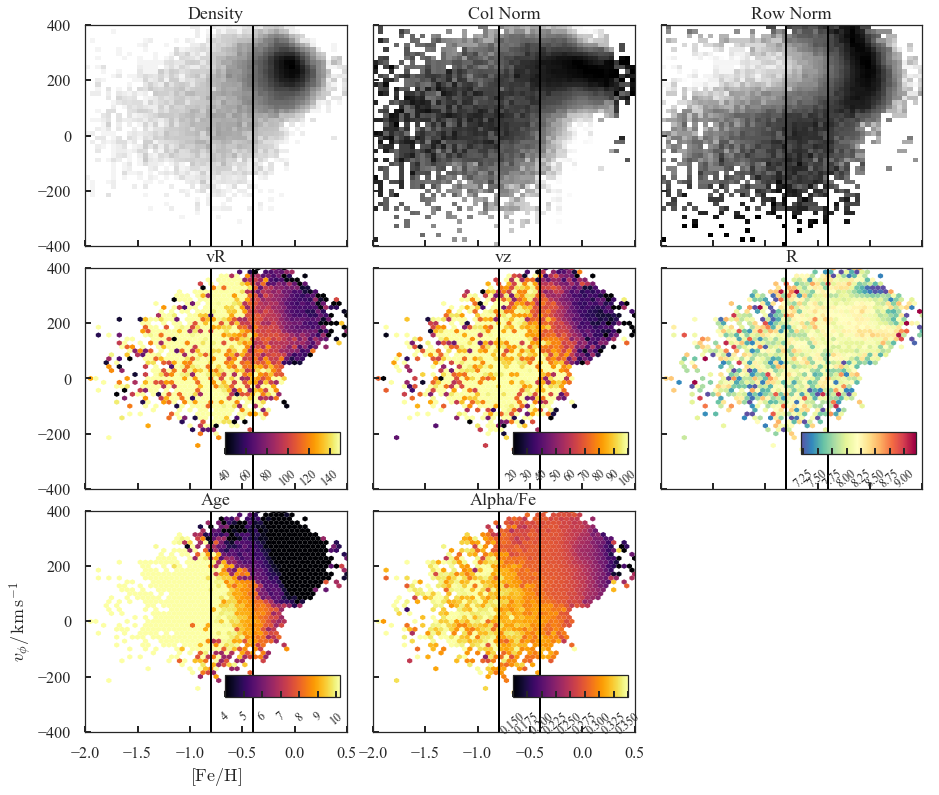

In [9]:
m12f=load_data('m12f_lsr0')
plot_grid(m12f,'m12f_lsr0')

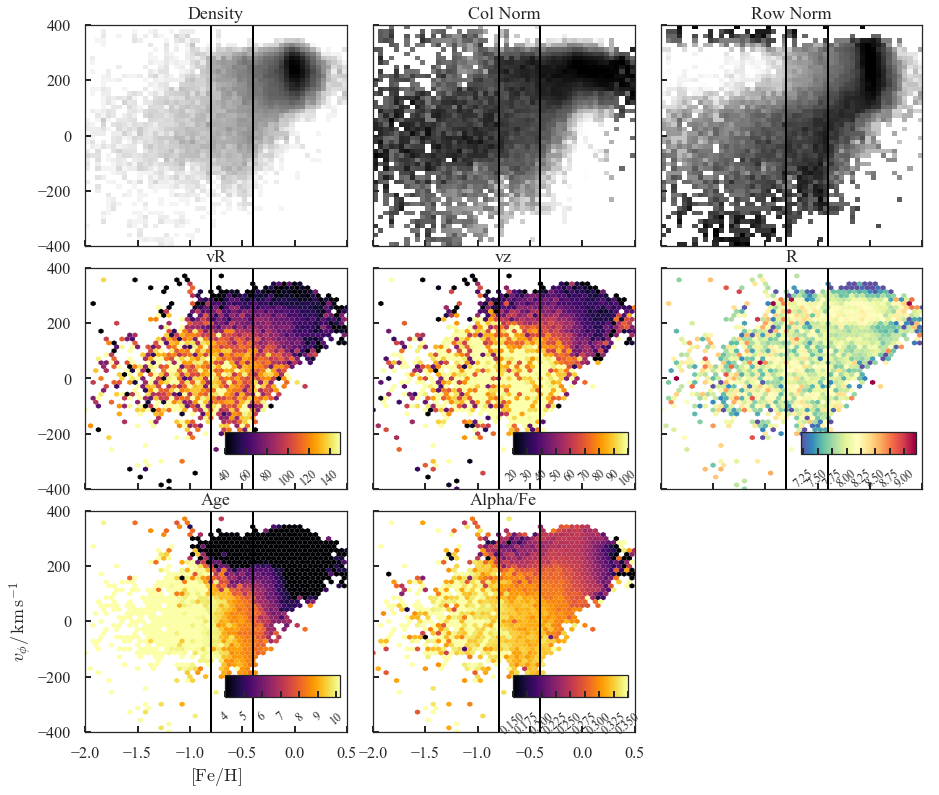

In [10]:
m12i=load_data('m12i_lsr0')
plot_grid(m12i,'m12i_lsr0')

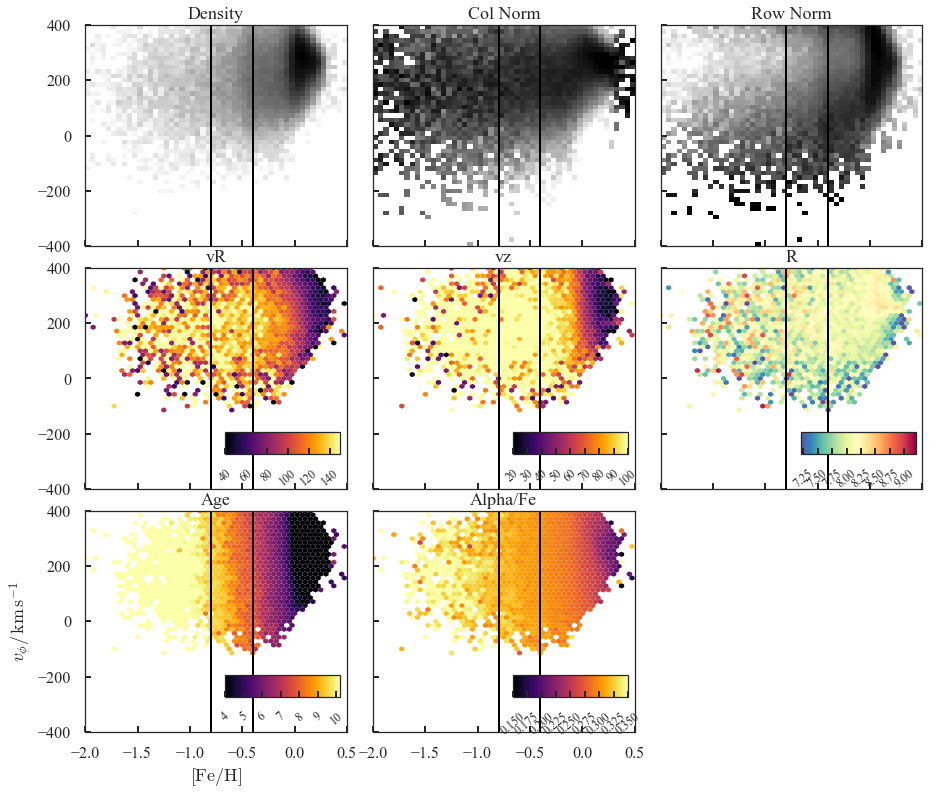

In [11]:
m12m=load_data('m12m_lsr0')
plot_grid(m12m,'m12m_lsr0')

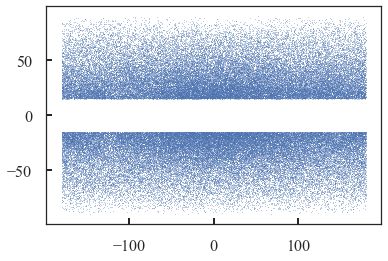

In [33]:
plt.plot(m12m['l'],m12m['b'],'.',ms=1)

## Output IDs

In [21]:
def save(data,lbl):
    data['source_id']=data['source_id'].astype('int64')
    data[['source_id','parentid']].to_csv('/data/jls/GaiaDR2/ananke/'+lbl+'.csv.gz',
                                          compression='gzip',index=False)

In [24]:
save(m12f,'m12f_index')
save(m12i,'m12i_index')
save(m12m,'m12m_index')

In [172]:
id_file_m12f = pd.read_csv('/data/jls/id_list.csv.gz')

In [174]:
data = load_data('m12f_lsr0')

In [178]:
indices = id_file_m12f.values[data['parentid']].flatten()

In [185]:
np.max(indices)

92449141

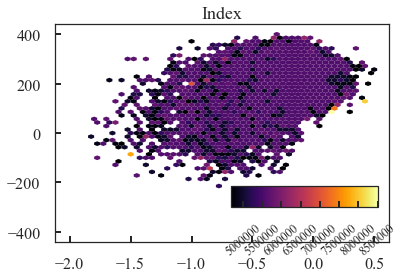

In [189]:
im=plt.hexbin(data.feh,-data.vphi,gridsize=50,
             extent=[-2.,0.5,-400.,400.],edgecolors="None",mincnt=3,
              C=data.parentid,reduce_C_function=np.nanmedian,cmap=plt.cm.inferno);
plt.title('Index')
inset_bar(plt.gca(),im)